## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [1]:
# Input info
cellr_in = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/jan21_2021/MTblacklist"#"/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_april08_2021_Croker/MTblacklist" 
outdir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/annotation/gff_A2_black/mergedSamples" #"/data/Mito_Trace/output/annotation/data/cd34norm/MTblacklist/mergedSamples/"

sample_names = "Control,Flt3l"#"Control,Flt3l,Input"
samples = "P2,J2"#"Input,Control,Flt3l"

# Parameters
nTop = 25000
cores = 24

In [2]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

In [3]:
samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

samples

[1] "Input"   "Control" "Flt3l"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(Rsamtools)
library(cowplot)
library(metap)
library(dplyr)
library(future)

plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Attaching SeuratObject

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required pa

## Merge all peaks

In [5]:
read.peaks <- function(exp, cellr_in){
    print('here')
    print(file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"))
    peaks <- read.table(
      file = file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )
    # convert to genomic ranges
    gr <- makeGRangesFromDataFrame(peaks)
    return(gr)
}


gr.full <- c(sapply(samples, read.peaks, cellr_in=cellr_in, USE.NAMES=F))

gr.full.c <- gr.full[[1]]
if (length(gr.full)>1){
    for (i in 2:length(gr.full)){
      gr.full.c <- c(gr.full.c, gr.full[[i]])
    }
}
combined.peaks <- reduce(x = c(gr.full.c))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

[1] "here"
[1] "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_april08_2021_Croker/MTblacklist/Input/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_april08_2021_Croker/MTblacklist/Control/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_april08_2021_Croker/MTblacklist/Flt3l/outs/filtered_peak_bc_matrix/peaks.bed"


GRanges object with 263336 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1        9872-10620      *
       [2]     chr1       96454-96767      *
       [3]     chr1     180638-181142      *
       [4]     chr1     191518-191976      *
       [5]     chr1     267762-268278      *
       ...      ...               ...    ...
  [263332]     chrY 56872076-56872403      *
  [263333]     chrY 56873720-56873847      *
  [263334]     chrY 56873946-56874635      *
  [263335]     chrY 56879619-56879842      *
  [263336]     chrY 56880257-56880611      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [6]:
if (file.exists(file.path(outdir, "allSamples.tmp.rds")))
{
    print("Loading tmp")
    allSE <- readRDS(file.path(outdir, "allSamples.tmp.rds"))

} else{
    allSE = c() 

    samples_df <- cbind(sample_names, samples)
    print('samples_df')
    print(samples_df)
    for (row in 1:nrow(samples_df)){
        exp <- (samples_df[[row, "samples"]])
        name <- (samples_df[[row, "sample_names"]]) 

        print('exp')
        print(exp)
        print('name')
        print(name)
        barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
        barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
        barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=name)
        frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")

        cells.meta.f <- file.path(cellr_in, exp, "outs", "singlecell.csv") 
        cells.meta <- as.data.frame(readr::read_csv(cells.meta.f)) %>% tibble::column_to_rownames(var="barcode") %>% tibble::add_column(proj=name)
        cells.meta <- cells.meta[rownames(cells.meta) %in% rownames(barcodes), ]

        # quantify multiome peaks in the scATAC-seq dataset


        print("Creating fragments object")
        frags.curr <- CreateFragmentObject(path = frag_file, cells= rownames(barcodes))
        #print(frags.curr)
        print("Quantifying peaks")
        ## Quantify peaks
        curr.counts <- FeatureMatrix(
          fragments = frags.curr,
          features = combined.peaks,
          cells = rownames(barcodes),
          process_n = cores
        )

        print("Creating chromatin assay")
        ## Create the objects and use simple filters
        curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr, min.cells = 10, min.features = 200)
        curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=name, meta.data=cells.meta)
        print('curr_assay')
        print(head(curr_assay))
        print('curr')
        print(head(curr[[]]))
        allSE = c(allSE, curr)
        #return(curr)
    }

    saveRDS(allSE, file.path(outdir, paste0("allSamples.tmp.rds")))

}
#allSE <- sapply(samples, create_frag, cellr_in=cellr_in)
allSE

[1] "Loading tmp"


[[1]]
An object of class Seurat 
147518 features across 6543 samples within 1 assay 
Active assay: ATAC (147518 features, 0 variable features)

[[2]]
An object of class Seurat 
149495 features across 11949 samples within 1 assay 
Active assay: ATAC (149495 features, 0 variable features)


## QC metrics

In [7]:

qc <- function(se){
    # extract gene annotations from EnsDb
    annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

    # change to UCSC style since the data was mapped to hg19
    #seqlevelsStyle(annotations) <- 'UCSC'
    genome(annotations) <- "hg38"
    
    # add the gene information to the object
    Annotation(se) <- annotations
    gene.activities <- GeneActivity(se)
    # compute nucleosome signal score per cell
    se <- NucleosomeSignal(object = se)
    
    Annotation(se) <- annotations
    # compute TSS enrichment score per cell
    se <- TSSEnrichment(object = se, fast = FALSE)

    # add blacklist ratio and fraction of reads in peaks
    se$pct_reads_in_peaks <- se$peak_region_fragments / se$passed_filters * 100
    se$blacklist_ratio <- se$blacklist_region_fragments / se$peak_region_fragments
    se$high.tss <- ifelse(se$TSS.enrichment > 2, 'High', 'Low')
    se$nucleosome_group <- ifelse(se$nucleosome_signal > 4, 'NS > 4', 'NS < 4')

    return(se)
}
vPlot <- function(se){
      vPlot <- VlnPlot(
      object = se,
      features = c('pct_reads_in_peaks', 'peak_region_fragments',
                   'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
      pt.size = 0.1,
      ncol = 5
    )  
    vPlot <- vPlot +    # Create grid of plots with title
             plot_annotation(title = se$orig.ident[[1]]) & 
             theme(plot.title = element_text(hjust = 0.5, size=15))
    #print(vPlot)
    return(vPlot)
}


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining int

[[1]]

[[2]]


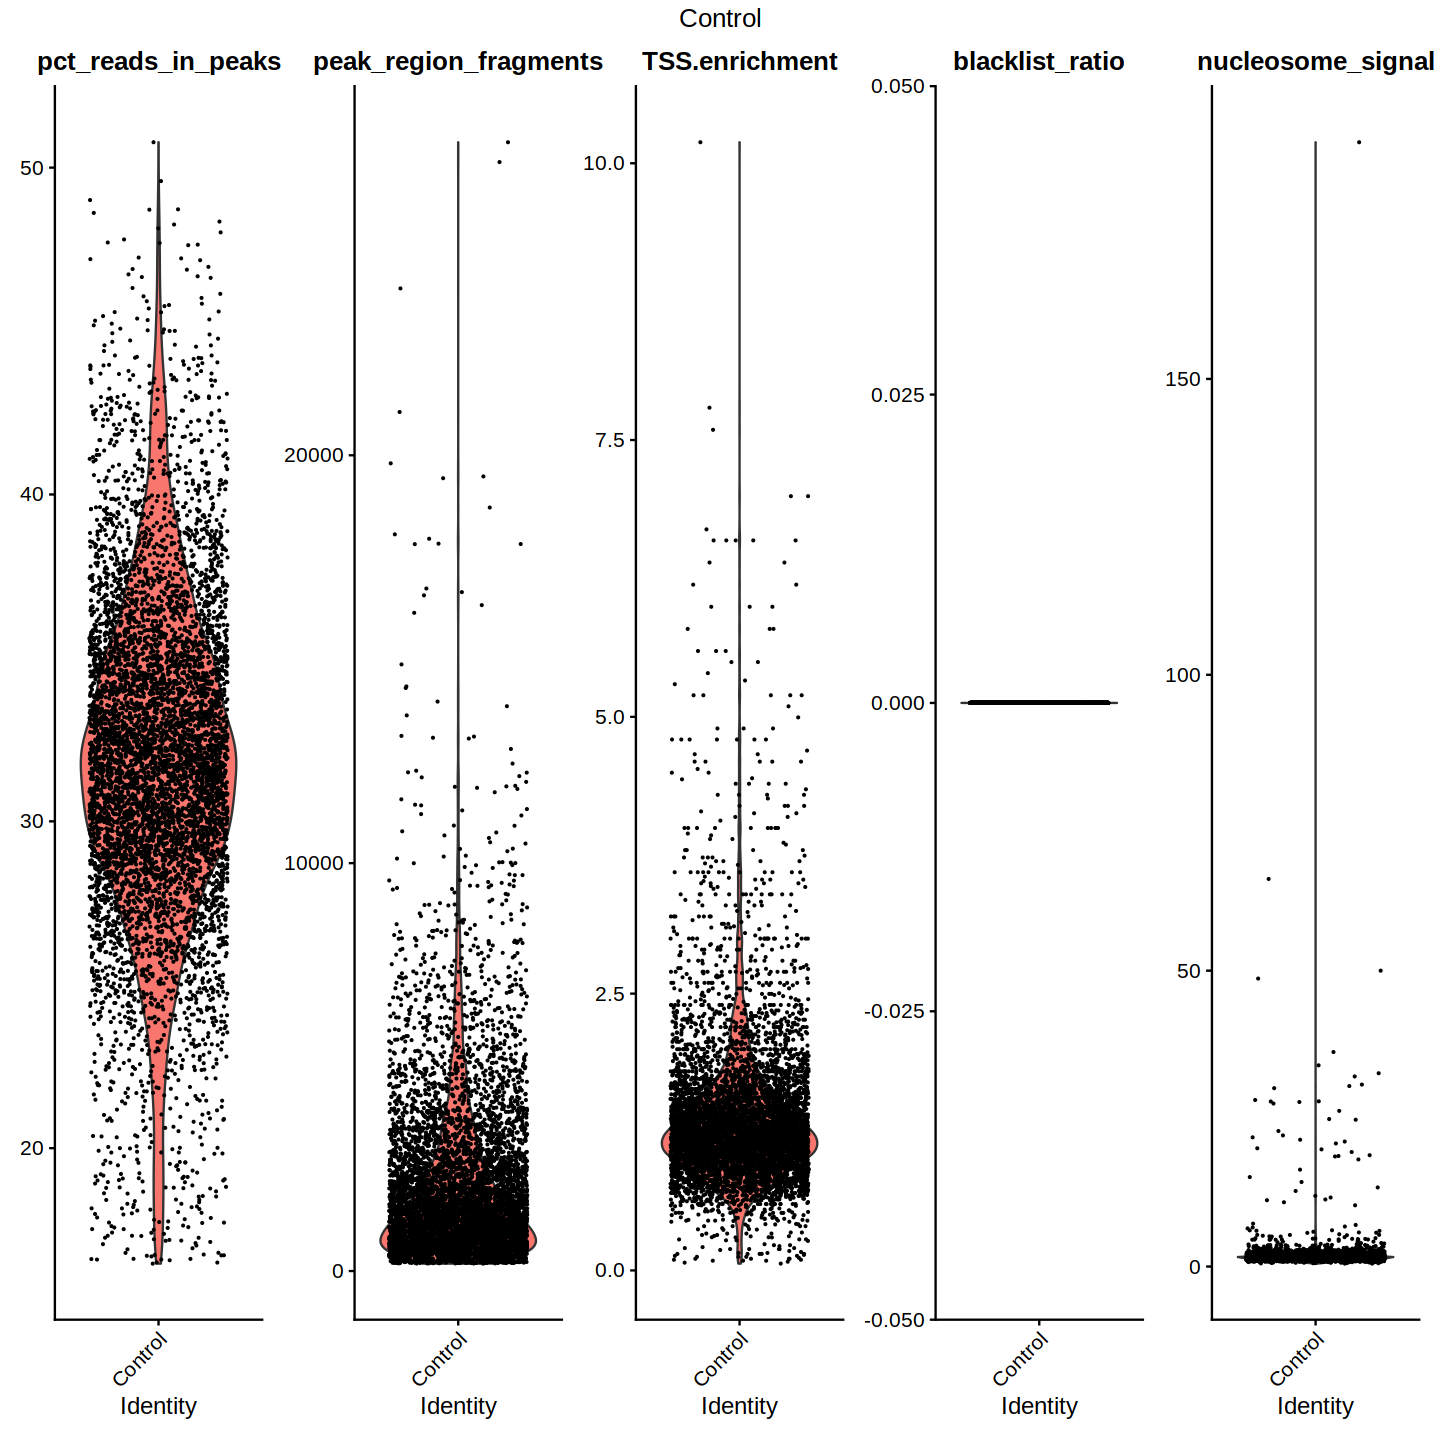

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



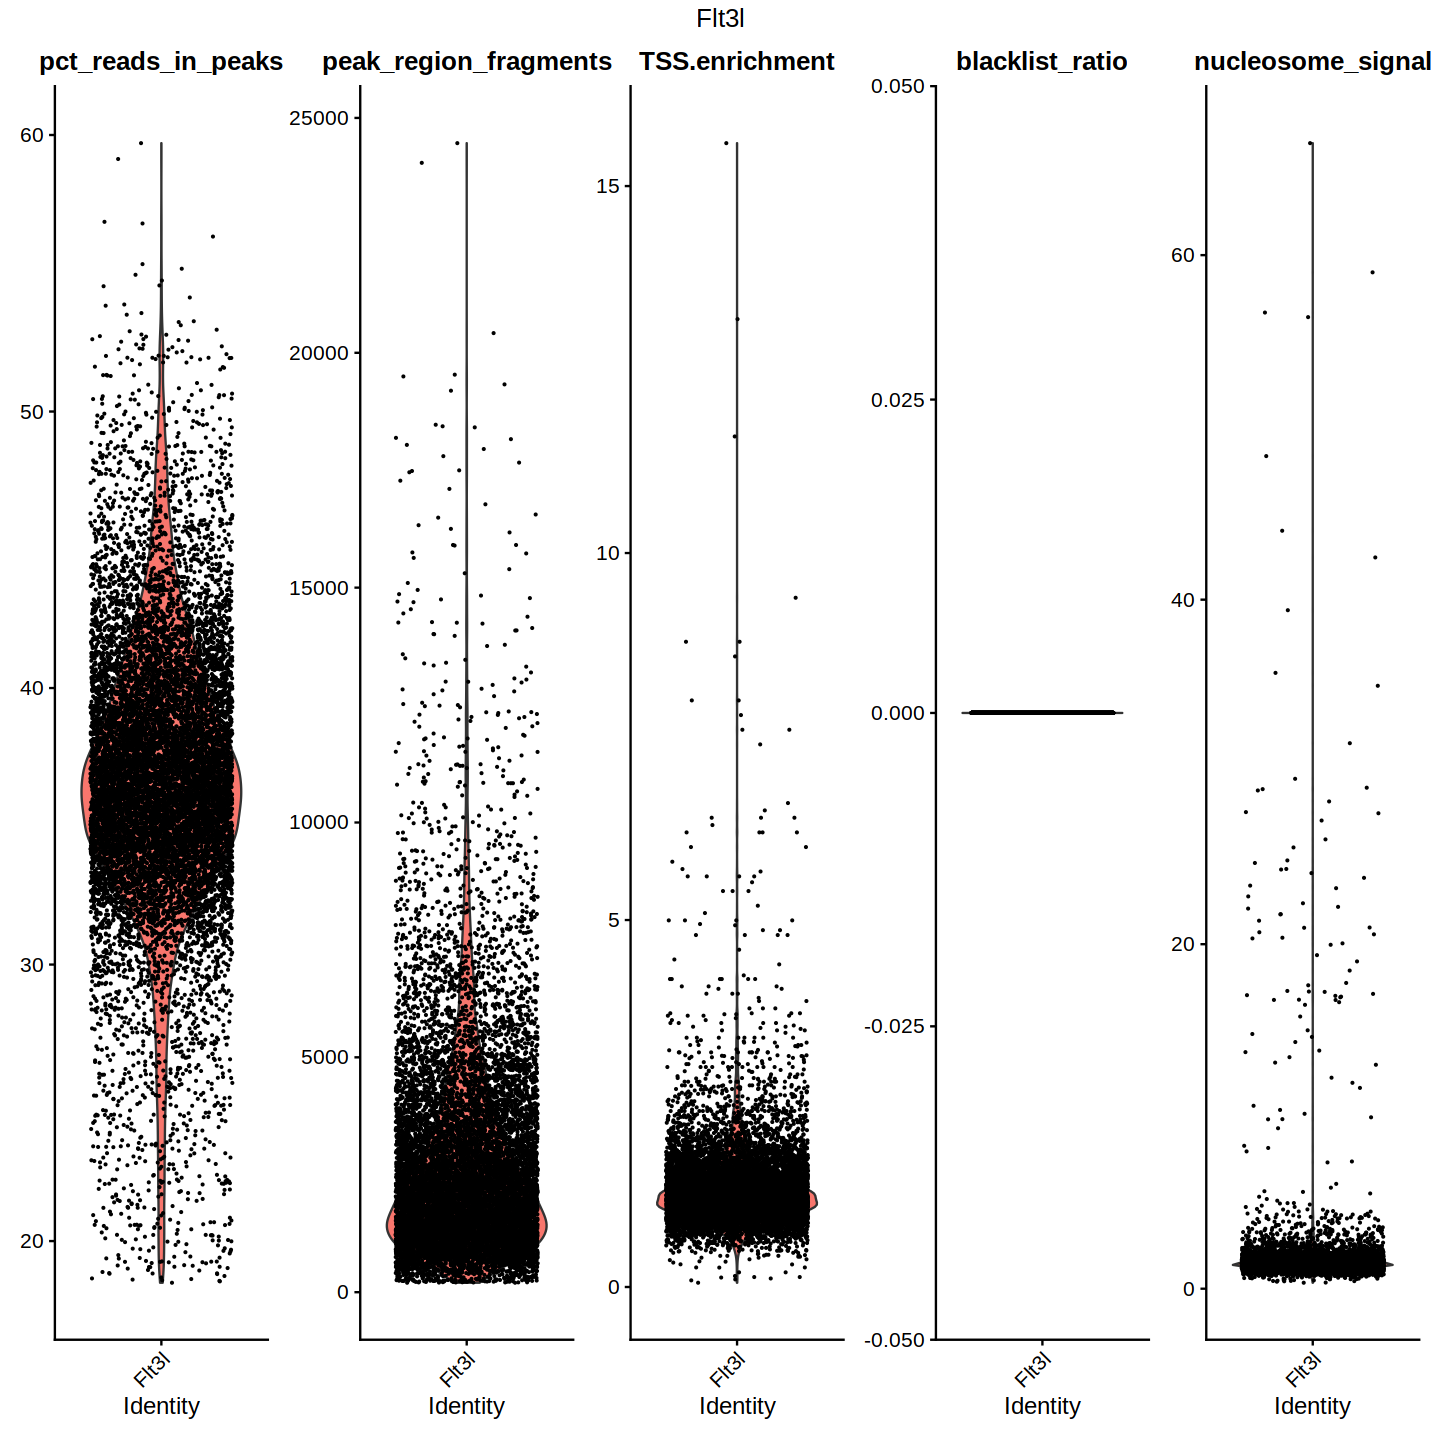

In [8]:
allSE <- lapply(allSE, qc)
saveRDS(allSE, file.path(outdir, paste0("allSamples.rds")))
lapply(allSE,vPlot)
ggsave(file.path(outdir, paste0("QC_01.png")))
ggsave(file.path(outdir, paste0("QC_01.pdf")))

In [9]:
allSE

[[1]]
An object of class Seurat 
147518 features across 6543 samples within 1 assay 
Active assay: ATAC (147518 features, 0 variable features)

[[2]]
An object of class Seurat 
149495 features across 11949 samples within 1 assay 
Active assay: ATAC (149495 features, 0 variable features)


In [10]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             dplyr_1.0.7              
 [3] metap_1.1                 cowplot_1.1.1            
 [5] Rsamtools_2.10.0          Biostrings_2.62.0        
 [7] XVector_0.34.0            magrittr_2.0.1           
 [9] data.table_1.14.2         patchwork_1.1.1          
[11] 